In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.5 MB/s eta 0:00:00


In [4]:
# 🔹 한글 폰트 설정 (Colab 환경)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.dates as mdates

# Colab에서 한글 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum -qq

# 폰트 경로 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font_prop = fm.FontProperties(fname=font_path, size=12)

# Matplotlib에 폰트 적용
mpl.rc('font', family=font_prop.get_name())  # 기본 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 한글 폰트 적용 확인
print(f"✅ 현재 설정된 폰트: {mpl.rcParams['font.family']}")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 현재 설정된 폰트: ['NanumGothic']


분석할 품목을 입력하세요 (여러 개는 쉼표로 구분, '끝' 입력 시 종료): 맥주
분석할 동을 입력하세요 (여러 개는 쉼표로 구분): 노은2동

 Processing SARIMA for: 맥주 - 노은2동


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

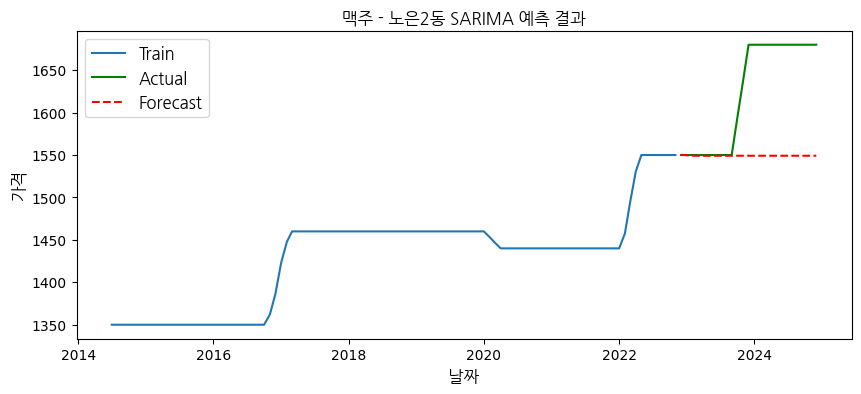

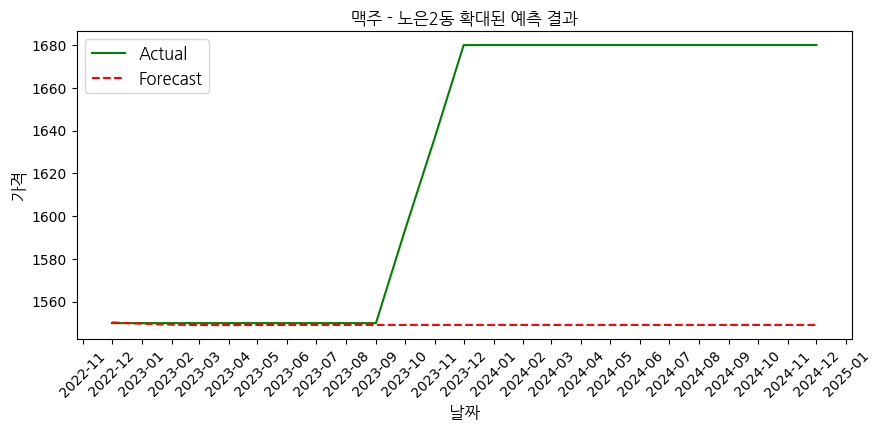

📊 평가 지표 for 맥주 - 노은2동
   - AIC: 498.54836387334115
   - BIC: 511.473201266694
   - RMSE: 96.36895805172607 (평균 가격 대비 6.74%)
   - MAPE: 4.393679845335775%
   - Ljung-Box p-value: 1.0 (p > 0.05이면 적절)
✅ RMSE 값이 평균 가격 대비 10% 이하 → 매우 좋은 모델


KeyboardInterrupt: Interrupted by user

In [11]:
#SARIMA 찾

# 🔹 1. 데이터 불러오기
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMA 모델
from statsmodels.stats.diagnostic import acorr_ljungbox  # Ljung-Box Test (잔차 검정)
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.dates as mdates


# 🔹 2. 데이터 불러오기
file_path = "/content/drive/MyDrive/khuda/대전_물가_IQR_이상치제거_결측치보완(커스텀한 1차 스플라인).csv"
df = pd.read_csv(file_path)

# 🔹 3. 날짜 변환 및 월별 평균 가격 계산
df['시간'] = pd.to_datetime(df['시간'])  # 날짜 변환
df['연월'] = df['시간'].dt.to_period('M')  # 연-월 단위 변환
df_monthly = df.groupby(['연월', '품목', '동'])['가격'].mean().reset_index()  # 동까지 포함하여 그룹화

# 🔹 4. 반복 입력을 통한 SARIMA 실행
while True:
    # 사용자 입력 받기
    target_items = input("분석할 품목을 입력하세요 (여러 개는 쉼표로 구분, '끝' 입력 시 종료): ")
    if target_items.strip() == "끝":
        print("✅ 분석을 종료합니다.")
        break  # 종료

    target_regions = input("분석할 동을 입력하세요 (여러 개는 쉼표로 구분): ")

    # 공백 제거 및 정리
    target_items = [item.strip() for item in target_items.split(",")]
    target_regions = [region.strip() for region in target_regions.split(",")]

    # 파일명 설정 (품목과 동을 조합하여 저장)
    file_name = f"sarima_{'_'.join(target_items)}_{'_'.join(target_regions)}.csv"

    # 🔹 5. 특정 품목 + 동 조합별 SARIMA 적용
    forecast_results = []

    for item in target_items:
        for region in target_regions:
            print(f"\n Processing SARIMA for: {item} - {region}")

            # 특정 품목 + 동 조합 데이터 필터링
            df_region = df_monthly[(df_monthly['품목'] == item) & (df_monthly['동'] == region)].copy()
            if df_region.empty:
                print(f"❌ 데이터 없음: {item} - {region}")
                continue

            df_region.set_index('연월', inplace=True)
            df_region.index = df_region.index.to_timestamp()

            # 🔸 80:20 train-test split
            split_index = int(len(df_region) * 0.8)
            train, test = df_region.iloc[:split_index], df_region.iloc[split_index:]

            # 데이터 개수가 부족하면 스킵
            if len(train) < 12:
                print(f"❌ Skipping {item} - {region} (데이터 부족)")
                continue

            # 🔸 최적의 (p, d, q) & (P, D, Q, m) 찾기
            auto_model = auto_arima(
                train['가격'],
                seasonal=True,
                m=12,
                stepwise=True,
                suppress_warnings=True
            )
            order = auto_model.order
            seasonal_order = auto_model.seasonal_order

            # 🔸 SARIMA 모델 학습
            model = SARIMAX(train['가격'], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit()

            # 🔸 모델 평가 지표
            aic = model_fit.aic
            bic = model_fit.bic
            forecast = model_fit.forecast(steps=len(test))

            # 음수 값 방지
            forecast[forecast < 0] = 0

            rmse = np.sqrt(np.mean((test['가격'].values - forecast.values) ** 2))
            mape = np.mean(np.abs((test['가격'].values - forecast.values) / test['가격'].values)) * 100
            ljungbox_p_value = acorr_ljungbox(model_fit.resid, lags=[10], return_df=True)['lb_pvalue'].values[0]

            data_mean = train['가격'].mean()
            rmse_ratio = (rmse / data_mean) * 100

            # 🔸 결과 저장
            forecast_results.append([item, region, test.index, test['가격'].values, forecast.values, aic, bic, rmse, mape, ljungbox_p_value, *order, *seasonal_order])

            # 🔸 그래프 그리기
            plt.figure(figsize=(10, 4))
            plt.plot(train.index, train['가격'], label="Train")
            plt.plot(test.index, test['가격'], label="Actual", color='green')
            plt.plot(test.index, forecast, label="Forecast", color='red', linestyle='dashed')
            plt.title(f"{item} - {region} SARIMA 예측 결과", fontproperties=font_prop)
            plt.xlabel("날짜", fontproperties=font_prop)
            plt.ylabel("가격", fontproperties=font_prop)
            plt.legend(prop=font_prop)
            plt.show()

            # 🔸 그래프 2: 확대된 Actual & Forecast만 표시 (월 단위)
            plt.figure(figsize=(10, 4))
            plt.plot(test.index, test['가격'], label="Actual", color='green')
            plt.plot(test.index, forecast, label="Forecast", color='red', linestyle='dashed')
            plt.title(f"{item} - {region} 확대된 예측 결과", fontproperties=font_prop)
            plt.xlabel("날짜", fontproperties=font_prop)
            plt.ylabel("가격", fontproperties=font_prop)
            plt.legend(prop=font_prop)
            plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # 월 단위로 X축 설정
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))  # "YYYY-MM" 포맷
            plt.xticks(rotation=45)
            plt.show()

            print(f"📊 평가 지표 for {item} - {region}")
            print(f"   - AIC: {aic}")
            print(f"   - BIC: {bic}")
            print(f"   - RMSE: {rmse} (평균 가격 대비 {rmse_ratio:.2f}%)")
            print(f"   - MAPE: {mape}%")
            print(f"   - Ljung-Box p-value: {ljungbox_p_value} (p > 0.05이면 적절)")

        if rmse_ratio < 10:
            print("✅ RMSE 값이 평균 가격 대비 10% 이하 → 매우 좋은 모델")
        elif rmse_ratio < 20:
            print("🟡 RMSE 값이 평균 가격 대비 10~20% → 적절한 모델")
        else:
            print("❌ RMSE 값이 평균 가격 대비 20% 이상 → 성능이 낮은 모델")
            print("---------------끝---------------------")
'''
    # 🔹 6. 예측 결과 저장
    df_results = pd.DataFrame(forecast_results, columns=['품목', '동', '날짜', '실제값', '예측값', 'AIC', 'BIC', 'RMSE', 'MAPE', 'Ljung-Box p-value', 'p', 'd', 'q', 'P', 'D', 'Q', 'm'])
    df_results.to_csv(f"/content/drive/MyDrive/khuda/{file_name}", index=False)

    print(f"\n✅ SARIMA 예측 결과가 저장되었습니다: {file_name}")
'''


